In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

pd.set_option('display.max_columns', 120)

data_dir = Path('/Users/mlwu/Documents/Academia/CMU/tepper_courses/Business Value Through Integrative Analytics/cases/case_1/code/data')
data_out = Path('/Users/mlwu/Documents/Academia/CMU/tepper_courses/Business Value Through Integrative Analytics/cases/case_1/code/data_out')
fig_path = Path('/Users/mlwu/Documents/Academia/CMU/tepper_courses/Business Value Through Integrative Analytics/cases/case_1/code/figs')
paths = {
    'dict': data_dir/'LCDataDictionary.xlsx',
    'lc2014': data_dir/'LoanStats3c.csv',
    'lc2015': data_dir/'LoanStats3d.csv'
}
paths

{'dict': PosixPath('/Users/mlwu/Documents/Academia/CMU/tepper_courses/Business Value Through Integrative Analytics/cases/case_1/code/data/LCDataDictionary.xlsx'),
 'lc2014': PosixPath('/Users/mlwu/Documents/Academia/CMU/tepper_courses/Business Value Through Integrative Analytics/cases/case_1/code/data/LoanStats3c.csv'),
 'lc2015': PosixPath('/Users/mlwu/Documents/Academia/CMU/tepper_courses/Business Value Through Integrative Analytics/cases/case_1/code/data/LoanStats3d.csv')}

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

# Define column roles
COLS = {
    "num_orig": [
        "loan_amnt","funded_amnt","installment","annual_inc",
        "dti","revol_bal","delinq_2yrs","open_acc","pub_rec"
    ],
    "cat_orig": [
        "term","grade","emp_length","home_ownership",
        "verification_status","purpose"
    ],
    "pct_orig": ["int_rate","revol_util"],
    "date_orig": ["issue_d","earliest_cr_line"],

    # Post-outcome fields \\ NOT for modeling \\ okay for descriptive, returns, timelines
    "post_outcome": ["loan_status","total_pymnt","last_pymnt_d","recoveries"],

    # Always keep ID
    "id": ["id"]
}

# Full ingest column list \\ your list + explicit role buckets above
cols_to_pick = (
    COLS["id"]
    + COLS["num_orig"]
    + COLS["cat_orig"]
    + COLS["pct_orig"]
    + COLS["date_orig"]
    + COLS["post_outcome"]
)

# Type buckets for assertion parity with your snippet
float_cols = COLS["num_orig"] + ["total_pymnt","recoveries"]
cat_cols   = COLS["cat_orig"] + ["loan_status"]
perc_cols  = COLS["pct_orig"]
date_cols  = COLS["date_orig"] + ["last_pymnt_d"]

# Strict check \\ allows 'id' to be the only untyped
missing_type = set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) - set(["id"])
assert missing_type == set(), f"Untyped columns: {missing_type}"

# Parse LC month-like strings to Timestamp at first of month \\ Tries '%b-%Y' (e.g., 'Dec-2014'), then ISO '%Y-%m-%d', then a permissive fallback
def parse_lc_month(s):
    s = s.astype(str).str.strip()
    # Try 'Dec-2014'
    out = pd.to_datetime(s, format='%b-%Y', errors='coerce')
    m = out.isna()
    if m.any():
        # ISO 'YYYY-MM-DD'
        out.loc[m] = pd.to_datetime(s[m], format='%Y-%m-%d', errors='coerce')
        m = out.isna()
    if m.any():
        # Final permissive fallback \\ avoids warnings elsewhere
        out.loc[m] = pd.to_datetime(s[m], errors='coerce')
    # Normalize to first-of-month for consistency (optional)
    out = out.dt.to_period('M').dt.to_timestamp('M') - pd.offsets.MonthBegin(1)
    return out

def coerce_types(df):
    df = df.copy()

    # Percentages
    for c in perc_cols:
        if c in df:
            df[c] = pd.to_numeric(df[c].astype(str).str.replace('%','', regex=False), errors='coerce')

    # Floats / ints
    for c in float_cols:
        if c in df:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # Categoricals
    for c in cat_cols:
        if c in df:
            df[c] = df[c].astype('category')

    # Dates
    for c in date_cols:
        if c in df:
            df[c] = pd.to_datetime(df[c], errors='coerce')

    # Term months + emp_length_num (engineering)
    if 'term' in df:
        df['term_months'] = pd.to_numeric(df['term'].astype(str).str.extract(r'(\d+)', expand=False), errors='coerce')
    if 'emp_length' in df:
        df['emp_length_num'] = pd.to_numeric(df['emp_length'].astype(str).str.extract(r'(\d+)', expand=False), errors='coerce')

    return df

# Start from the canonical ingest set \\ drop missing columns with warning
def build_frames(raw_df):
    present = [c for c in cols_to_pick if c in raw_df.columns]
    missing = [c for c in cols_to_pick if c not in raw_df.columns]
    if missing:
        print("Warning — missing expected columns:", missing)

    df_ingest = raw_df[present].copy()
    df_ingest = coerce_types(df_ingest)

    ## Add modeling-friendly encodings as needed (optional extension)

    # Create a leakage-safe modeling frame \\ drop `post_outcome``
    df_model = df_ingest.drop(columns=[c for c in COLS["post_outcome"] if c in df_ingest.columns])

    return df_ingest, df_model

In [3]:
import io
import pandas as pd
from pathlib import Path

def _find_header_row(path: Path, key_cols=('loan_amnt','int_rate','grade')):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for i, line in enumerate(f):
            if all(k in line.lower() for k in key_cols):            # header row should contain key columns \\ comma-separated
                return i
    return 0

def load_lc_csv(path: Path):
    hdr = _find_header_row(path)
    df = pd.read_csv(
        path,
        skiprows=hdr,
        engine="python"         # don't pass low_memory when using engine="python"
    )
    df = df.dropna(how="all")
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    return df

In [4]:
# Load 2014/2015 into df14/df15
df14 = load_lc_csv(paths["lc2014"])
df15 = load_lc_csv(paths["lc2015"])
print("Loaded:", df14.shape, df15.shape)

# Build ingest/model frames
df14_ingest, df14_model = build_frames(df14)
df15_ingest, df15_model = build_frames(df15)

# Sanity check
set(df14_model.columns) & set(COLS["post_outcome"])  # should be empty set
set(df15_model.columns) & set(COLS["post_outcome"])  # should be empty set
leak = set(df14_model.columns) & set(COLS["post_outcome"])
assert not leak, f"Leakage columns slipped into model: {leak}"

# Keep list & clean() before you use them
keep = [
    'id','loan_amnt','funded_amnt','term','int_rate','grade','emp_length','home_ownership','annual_inc',
    'verification_status','issue_d','loan_status','purpose','dti','delinq_2yrs','earliest_cr_line','open_acc',
    'pub_rec','revol_bal','revol_util','recoveries','total_pymnt'
]

keep = [
    'id','loan_amnt','funded_amnt','term','int_rate','grade','emp_length','home_ownership','annual_inc',
    'verification_status','issue_d','loan_status','purpose','dti','delinq_2yrs','earliest_cr_line','open_acc',
    'pub_rec','revol_bal','revol_util','recoveries','total_pymnt'
]

def clean(df):
    df = df.copy()
    cols = [c for c in keep if c in df.columns]
    df = df[cols]

    # percentages -> numeric
    if 'int_rate' in df:
        df['int_rate'] = pd.to_numeric(df['int_rate'].astype(str).str.replace('%', '', regex=False), errors='coerce')
    if 'revol_util' in df:
        df['revol_util'] = pd.to_numeric(df['revol_util'].astype(str).str.replace('%', '', regex=False), errors='coerce')

    # term(s) -> months
    if 'term' in df:
        df['term_months'] = pd.to_numeric(
            df['term'].astype(str).str.extract(r'(\d+)', expand=False),
            errors='coerce'
        )

    # dates
    if 'issue_d' in df:
        df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')
    if 'earliest_cr_line' in df:
        df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], errors='coerce')

    # numerics
    num_cols = ['loan_amnt','funded_amnt','annual_inc','dti','delinq_2yrs','open_acc','pub_rec',
                'revol_bal','recoveries','total_pymnt']
    for c in num_cols:
        if c in df:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # categories
    for c in ['grade','purpose','home_ownership','verification_status','emp_length','term','loan_status']:
        if c in df:
            df[c] = df[c].astype('category')

    return df

# Create c14/c15
c14, c15 = clean(df14), clean(df15)
c14.head(3)

# Save cleaned data
df14_ingest.to_csv(data_out/"lc2014_ingest.csv", index=False)
df14_model.to_csv(data_out/"lc2014_model.csv", index=False)
df15_ingest.to_csv(data_out/"lc2015_ingest.csv", index=False)
df15_model.to_csv(data_out/"lc2015_model.csv", index=False)

print("Saved cleaned data to", data_out)

Loaded: (235631, 144) (421097, 144)


/var/folders/s1/_87stjnd5c12cm_bjtxx4xlm0000gn/T/ipykernel_3882/924371866.py:83: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors='coerce')
/var/folders/s1/_87stjnd5c12cm_bjtxx4xlm0000gn/T/ipykernel_3882/924371866.py:83: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors='coerce')
/var/folders/s1/_87stjnd5c12cm_bjtxx4xlm0000gn/T/ipykernel_3882/924371866.py:83: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors='coerce')
/var/folders/s1/_87stjnd5c12cm_bjtxx4xlm0000gn/T/ipykernel

Saved cleaned data to /Users/mlwu/Documents/Academia/CMU/tepper_courses/Business Value Through Integrative Analytics/cases/case_1/code/data_out



2014 (3c) Basic Summary


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
id,2,2,Total amount funded in policy code 1: 3503840175,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,235629.0,NaN,NaN,NaN,14870.156793,1000.0,8325.0,13000.0,20000.0,35000.0,8438.318193
funded_amnt,235629.0,NaN,NaN,NaN,14870.156793,1000.0,8325.0,13000.0,20000.0,35000.0,8438.318193
term,235629,2,36 months,162570,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,235629.0,NaN,NaN,NaN,13.769509,6.0,10.99,13.65,16.29,26.06,4.326192
grade,235629,7,C,66565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_length,223610,11,10+ years,79505,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,235629,4,MORTGAGE,119937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,235629.0,NaN,NaN,NaN,74854.148281,3000.0,45377.0,65000.0,90000.0,7500000.0,55547.533374
verification_status,235629,3,Source Verified,97741,NaN,NaN,NaN,NaN,NaN,NaN,NaN


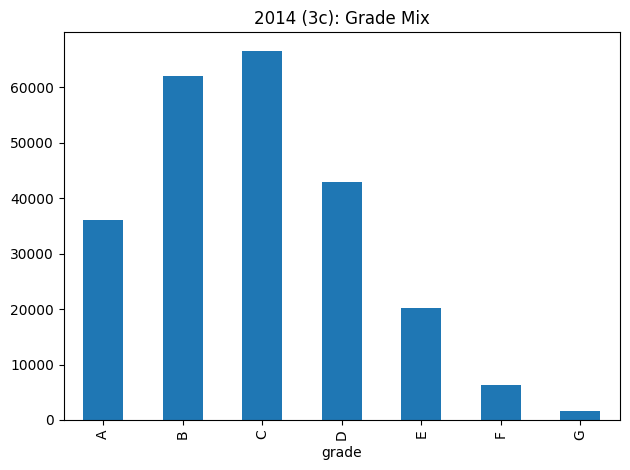

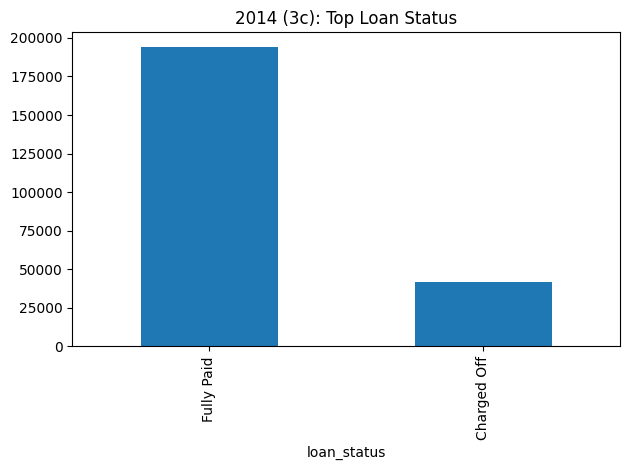


2015 (3d) Basic Summary


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
id,2,2,Total amount funded in policy code 1: 6417608175,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,421095.0,NaN,NaN,NaN,15240.285862,1000.0,8500.0,14000.0,20000.0,35000.0,8571.325901
funded_amnt,421095.0,NaN,NaN,NaN,15240.285862,1000.0,8500.0,14000.0,20000.0,35000.0,8571.325901
term,421095,2,36 months,283173,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,421095.0,NaN,NaN,NaN,12.599066,5.32,9.17,12.29,15.59,28.99,4.318822
grade,421095,7,C,120567,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_length,397278,11,10+ years,141521,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,421095,4,MORTGAGE,207683,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,421095.0,NaN,NaN,NaN,76965.608663,0.0,46000.0,65000.0,91690.5,9500000.0,73949.961469
verification_status,421095,3,Source Verified,179565,NaN,NaN,NaN,NaN,NaN,NaN,NaN


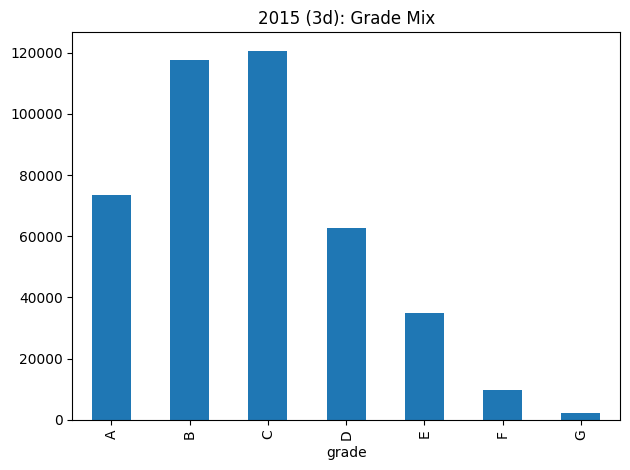

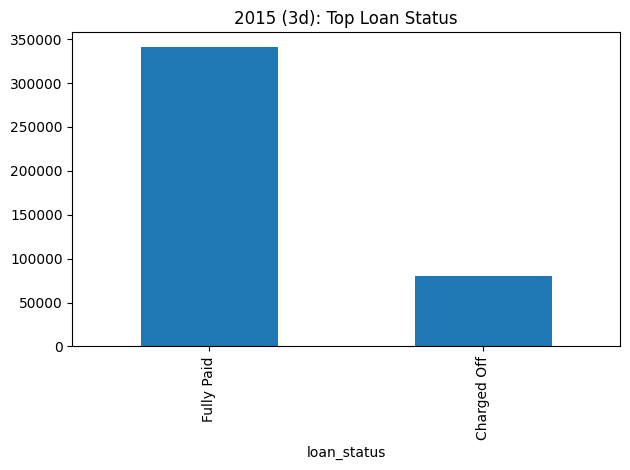

In [5]:
def quick_eda(df, name):
    print(f"\n{name} Basic Summary")
    display(df.describe(include='all').transpose().iloc[:25])
    
    # Grade distribution
    if 'grade' in df:
        ax = df['grade'].value_counts().sort_index().plot(kind='bar', title=f'{name}: Grade Mix')
        plt.tight_layout()
        plt.savefig(fig_path/f"{name.lower().replace(' ','_')}_grade_mix.png", dpi=300)
        plt.show()

    # Status breakdown
    if 'loan_status' in df:
        ax = df['loan_status'].value_counts().head(10).plot(kind='bar', title=f'{name}: Top Loan Status')
        plt.tight_layout()
        plt.savefig(fig_path/f"{name.lower().replace(' ','_')}_status_breakdown.png", dpi=300)
        plt.show()

quick_eda(c14, '2014 (3c)')
quick_eda(c15, '2015 (3d)')

In [6]:
# Cluster & Grade crosstab \\ row-normalized by cluster
ct = (pd.crosstab(df["cluster_k"], y_grade, normalize="index")
        .reindex(columns=list("ABCDEFG"), fill_value=0.0)
        .round(3))
display(ct)

# Heatmap
fig, ax = plt.subplots(figsize=(8, 4.2))
im = ax.imshow(ct.values, aspect="auto", cmap="Blues", vmin=0, vmax=ct.values.max())
ax.set_xticks(range(ct.shape[1])); ax.set_xticklabels(ct.columns)
ax.set_yticks(range(ct.shape[0])); ax.set_yticklabels([f"C{i}" for i in ct.index])
ax.set_xlabel("LendingClub Grade"); ax.set_ylabel("Cluster")
ax.set_title("Cluster & Grade (row-normalized)")
for i in range(ct.shape[0]):
    for j in range(ct.shape[1]):
        ax.text(j, i, f"{ct.iloc[i,j]:.2f}", va="center", ha="center", fontsize=8)
fig.colorbar(im, ax=ax, shrink=0.8, label="Share")
fig.tight_layout()
fig.savefig(fig_path / "cluster_grade_heatmap.png", dpi=300)
plt.show()

NameError: name 'df' is not defined

In [ ]:
def label_and_returns(df):
    df = df.copy()
    status = df['loan_status'].astype(str).str.lower() if 'loan_status' in df else pd.Series(index=df.index, dtype=str)
    default_like = status.str.contains('charge|default')
    fully_paid = status.str.contains('fully paid')
    df['defaulted'] = np.where(default_like, 1, np.where(fully_paid, 0, np.nan))
    # returns
    if {'total_pymnt','funded_amnt'}.issubset(df.columns):
        df['roi'] = (df['total_pymnt'] - df['funded_amnt']) / df['funded_amnt']
        df['annual_ret'] = (1 + df['roi']).pow(12/df['term_months']) - 1
    return df

r14 = label_and_returns(c14)
r15 = label_and_returns(c15)
r14[['loan_status','defaulted','roi','annual_ret']].head(5)

,loan_status,defaulted,roi,annual_ret
0,Fully Paid,0.0,0.159491,0.030039
1,Charged Off,1.0,-0.364261,-0.140143
2,Charged Off,1.0,-0.701702,-0.331835
3,Fully Paid,0.0,0.497293,0.084080
4,Fully Paid,0.0,0.190768,0.035537


In [ ]:
# Cohen-style return scenarios
def cohen_returns(df):
    d = df.copy()
    for col in ['funded_amnt','total_pymnt','recoveries','term_months']:
        if col not in d.columns: d[col] = np.nanargmax
    # Optimistic
    d['ret_opt'] = (d['total_pymnt'] - d['funded_amnt']) / d['funded_amnt']

    # Intermediate \\ subtract 1% servicing fee on total payments
    d['ret_int'] = ((0.99 * d['total_pymnt']) - d['funded_amnt']) / d['funded_amnt']

    # Pessimistic \\ if default, only count recoveries \\ if fully paid, use intermediate
    is_default = d['defaulted'] == 1
    is_paid = d['defaulted'] == 0
    base = ((0.99 * d['total_pymnt']) - d['funded_amnt']) / d['funded_amnt']
    pess_default = ((d['recoveries'].fillna(0)) - d['funded_amnt']) / d['funded_amnt']
    d['ret_pess'] = np.where(is_default, pess_default, np.where(is_paid, base, np.nan))
    
    # Annualize each scenario by term
    for col in ['ret_opt','ret_int','ret_pess']:
        d[col + '_ann'] = (1 + d[col]).pow(12 / d['term_months']) - 1
    return d

r14 = cohen_returns(r14)
r15 = cohen_returns(r15)

def show_returns_summary(df, label):
    tmp = df.dropna(subset=['ret_opt','ret_int','ret_pess'])
    print(f"\n{label} — Median Annualized Return by Scenario")
    print(tmp[['ret_opt_ann','ret_int_ann','ret_pess_ann']].median().round(4))
    if 'grade' in tmp.columns:
        print("\nBy Grade (annualized, median)")
        display(tmp.groupby('grade')[['ret_opt_ann','ret_int_ann','ret_pess_ann']].median().round(4))

show_returns_summary(r14,'2014')
show_returns_summary(r15,'2015')


2014 — Median Annualized Return by Scenario
ret_opt_ann     0.0446
ret_int_ann     0.0416
ret_pess_ann    0.0406
dtype: float64

By Grade (annualized, median)


/var/folders/s1/_87stjnd5c12cm_bjtxx4xlm0000gn/T/ipykernel_33981/1401743174.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(tmp.groupby('grade')[['ret_opt_ann','ret_int_ann','ret_pess_ann']].median().round(4))


,ret_opt_ann,ret_int_ann,ret_pess_ann
grade,,,
A,0.0330,0.0295,0.0295
B,0.0470,0.0435,0.0435
C,0.0566,0.0536,0.0532
D,0.0590,0.0562,0.0548
E,0.0553,0.0528,0.0479
F,0.0529,0.0505,0.0432
G,0.0359,0.0337,0.0184



2015 — Median Annualized Return by Scenario
ret_opt_ann     0.0397
ret_int_ann     0.0366
ret_pess_ann    0.0359
dtype: float64

By Grade (annualized, median)


/var/folders/s1/_87stjnd5c12cm_bjtxx4xlm0000gn/T/ipykernel_33981/1401743174.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(tmp.groupby('grade')[['ret_opt_ann','ret_int_ann','ret_pess_ann']].median().round(4))


,ret_opt_ann,ret_int_ann,ret_pess_ann
grade,,,
A,0.0310,0.0276,0.0276
B,0.0418,0.0384,0.0383
C,0.0525,0.0495,0.0491
D,0.0540,0.0511,0.0495
E,0.0431,0.0407,0.0352
F,0.0275,0.0253,0.0105
G,0.0164,0.0144,-0.0026


/var/folders/s1/_87stjnd5c12cm_bjtxx4xlm0000gn/T/ipykernel_33981/953147705.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


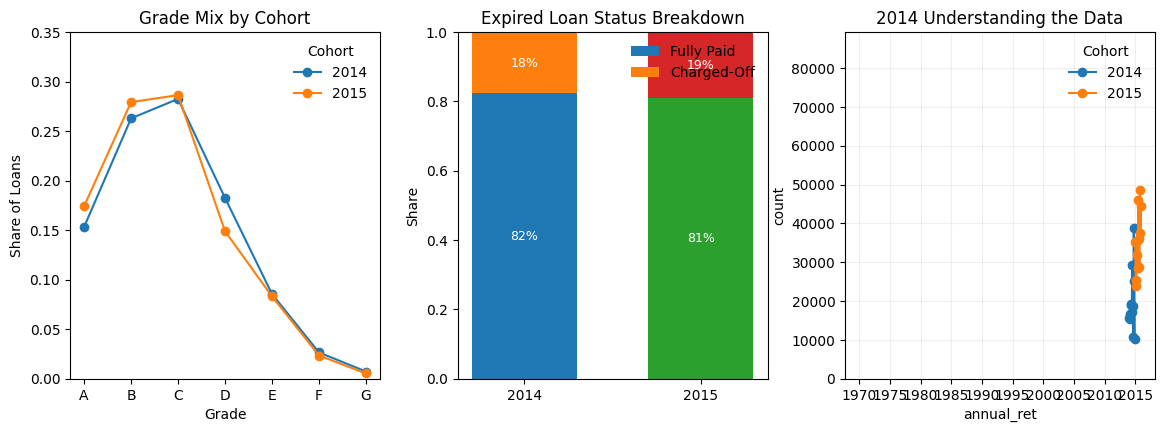

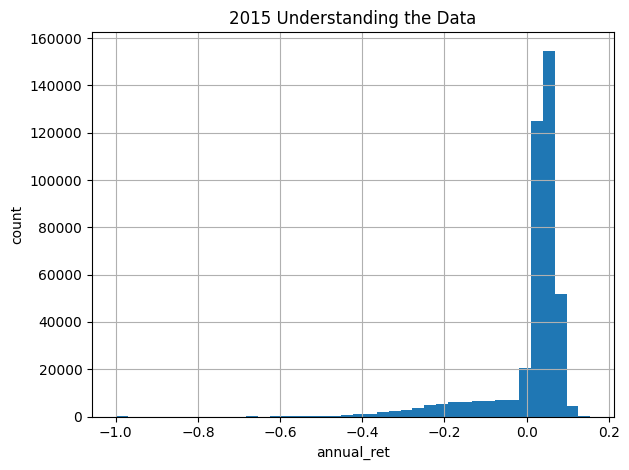

In [ ]:
# Ensure cohort exists, then rebuild df
r14 = r14.copy().assign(cohort=2014)
r15 = r15.copy().assign(cohort=2015)
df  = pd.concat([r14, r15], ignore_index=True)

# Build Panel A: Grade mix (share by grade, per cohort)
grade_order = list("ABCDEFG")
grade_counts = (
    df.assign(grade=lambda x: x["grade"].astype(str).str.upper().str[0])
      .query("grade in @grade_order")
      .groupby(["cohort", "grade"], as_index=False)
      .size()
)

grade_counts["share"] = grade_counts.groupby("cohort")["size"].transform(lambda s: s / s.sum())
grade_mix = grade_counts.loc[:, ["cohort", "grade", "share"]]

if "grade" not in df.columns:
    raise KeyError("Missing 'grade' column. Make sure the LC CSVs are loaded correctly.")

ls = df.get("loan_status", pd.Series(index=df.index, dtype=object)).astype(str).str.lower()

fully_mask = (
    ls.str.contains("fully paid", na=False)
    | ls.str.contains(r"does not meet the credit policy.*status:\s*fully paid", regex=True, na=False)
)

charged_mask = (
    ls.str.contains("charged off", na=False)
    | ls.str.contains(r"\bdefault\b", regex=True, na=False)
    | ls.str.contains(r"does not meet the credit policy.*status:\s*charged off", regex=True, na=False)
)

df["status_simple"] = np.where(fully_mask, "Fully Paid",
                        np.where(charged_mask, "Charged-Off", "Non-Expired"))

# Build Panel B \\ no .query()
expired = df[df["status_simple"] != "Non-Expired"]

status_counts = (
    expired.groupby(["cohort", "status_simple"], as_index=False)
           .size()
)
status_counts["share"] = status_counts.groupby("cohort")["size"].transform(lambda s: s / s.sum())
status_break = status_counts.loc[:, ["cohort", "status_simple", "share"]]

# Build Panel C \\ Cohort comparison (monthly issuance counts)
monthly_counts = (df.dropna(subset=["issue_d"])
                    .assign(month=lambda x: x["issue_d"].dt.to_period("M").dt.to_timestamp())
                    .groupby(["cohort","month"]).size()
                    .rename("n").reset_index())

# Plot
fig = plt.figure(figsize=(14, 4.5))
gs  = fig.add_gridspec(1, 3, wspace=0.25)

# Panel A \\ Grade mix
ax1 = fig.add_subplot(gs[0,0])
for k, grp in grade_mix.groupby("cohort"):
    ax1.plot(grade_order,
             [grp.loc[grp["grade"]==g, "share"].values[0] if g in grp["grade"].values else 0 for g in grade_order],
             marker="o", label=k)
ax1.set_title("Grade Mix by Cohort")
ax1.set_xlabel("Grade")
ax1.set_ylabel("Share of Loans")
ax1.set_ylim(0, max(0.35, grade_mix["share"].max()*1.1))
ax1.legend(title="Cohort", frameon=False)

# Panel B \\ Status breakdown (100% bars)
ax2 = fig.add_subplot(gs[0,1])
for i, k in enumerate(sorted(status_break["cohort"].unique())):
    s = status_break[status_break["cohort"]==k].set_index("status_simple")["share"]
    fully  = float(s.get("Fully Paid", 0.0))
    charge = float(s.get("Charged-Off", 0.0))
    ax2.bar(i, fully, width=0.6)
    ax2.bar(i, charge, bottom=fully, width=0.6)
    ax2.text(i, fully/2, f"{fully:.0%}", ha="center", va="center", fontsize=9, color="white")
    ax2.text(i, fully + charge/2, f"{charge:.0%}", ha="center", va="center", fontsize=9, color="white")
ax2.set_title("Expired Loan Status Breakdown")
ax2.set_xticks(range(len(sorted(status_break['cohort'].unique()))), sorted(status_break['cohort'].unique()))
ax2.set_ylabel("Share")
ax2.set_ylim(0, 1.0)
ax2.legend(["Fully Paid","Charged-Off"], frameon=False, loc="upper right")

# Panel C \\ Cohort comparison (monthly issuance)
ax3 = fig.add_subplot(gs[0,2])
for k, grp in monthly_counts.groupby("cohort"):
    grp = grp.sort_values("month")
    ax3.plot(grp["month"], grp["n"], marker="o", label=k)
ax3.set_title("Monthly Issuance Counts")
ax3.set_xlabel("Issue Month")
ax3.set_ylabel("Number of Loans")
ax3.legend(title="Cohort", frameon=False)
ax3.grid(alpha=0.2)

for label, df in [('2014', r14), ('2015', r15)]:
    tmp = df.dropna(subset=['annual_ret'])
    if not tmp.empty:
        tmp['annual_ret'].hist(bins=40)
        plt.title(f"{label} Understanding the Data")
        plt.xlabel("annual_ret")
        plt.ylabel("count")
        plt.tight_layout()
        Path(fig_path).mkdir(parents=True, exist_ok=True)
        plt.savefig(fig_path / f"{label.lower()}_annual_ret_hist.png", dpi=300)
        plt.show()

In [ ]:
# M1/M2/M3 per-loan annualized returns
RET_SERVICING_FEE = 0.01  # 1% servicing fee on payments (adjust if your case specifies a different fee)
ANNUALIZE_ON = "term_months"

df = df.copy()

# Safety feature: coerce the used columns to numeric
for c in ["funded_amnt", "total_pymnt", "recoveries", "int_rate_num", ANNUALIZE_ON]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Annualize a raw ROI over `term_months`
def annualize(roi, months):
    m = np.where(months > 0, months, np.nan)
    return (1.0 + roi) ** (12.0 / m) - 1.0

# Outcomes
status = df.get("loan_status", pd.Series(index=df.index, dtype=object)).astype(str).str.lower()
is_expired = (status.str.contains("fully paid", na=False) |
              status.str.contains("charged off", na=False) |
              status.str.contains("default", na=False) |
              status.str.contains("does not meet the credit policy", na=False))

# M1 (Optimistic) \\ investor receives all reported cash flows, total payment includes recoveries, net of servicing
net_cash_m1 = (df["total_pymnt"] * (1 - RET_SERVICING_FEE))
roi_m1 = (net_cash_m1 - df["funded_amnt"]) / df["funded_amnt"]         # ROI = (net_cash - principal) / principal
df["annual_ret_m1"] = annualize(roi_m1, df[ANNUALIZE_ON])

# M2 (Pessimistic) \\ loans that are not Fully Paid, assume NO recoveries were realized, strip recoveries out of total_pymnt \\ still net of servicing on what was actually paid
recov = df["recoveries"].fillna(0.0)
net_cash_m2 = (df["total_pymnt"] - recov) * (1 - RET_SERVICING_FEE)
roi_m2 = (net_cash_m2 - df["funded_amnt"]) / df["funded_amnt"]
df["annual_ret_m2"] = annualize(roi_m2, df[ANNUALIZE_ON])

# M3 (Intermediate) \\ treat recoveries partially (e.g., 50% credit to investor) and subtract a tiny extra fee to reflect timing/frictions
RECOVERY_CREDIT = 0.50      # credit 50% of recoveries
EXTRA_FRICTION = 0.0025     # 25 bps extra friction on paid amounts
net_cash_m3 = ( (df["total_pymnt"] - recov + RECOVERY_CREDIT * recov) * (1 - RET_SERVICING_FEE - EXTRA_FRICTION) )
roi_m3 = (net_cash_m3 - df["funded_amnt"]) / df["funded_amnt"]
df["annual_ret_m3"] = annualize(roi_m3, df[ANNUALIZE_ON])

# Focus the summary on expired loans (optional safer comparison)
expired_mask = is_expired.fillna(False)
summarize_cols = ["annual_ret_m1", "annual_ret_m2", "annual_ret_m3"]

# Grade & Term summary (mean, median, count)
grade_term = (
    df.loc[expired_mask, ["grade", "term_months", *summarize_cols]]
      .assign(grade=lambda x: x["grade"].astype(str).str.upper().str[0])
      .groupby(["grade", "term_months"])
      .agg(**{
          "N": ("annual_ret_m3", "count"),
          "m1_mean": ("annual_ret_m1", "mean"),
          "m1_median": ("annual_ret_m1", "median"),
          "m2_mean": ("annual_ret_m2", "mean"),
          "m2_median": ("annual_ret_m2", "median"),
          "m3_mean": ("annual_ret_m3", "mean"),
          "m3_median": ("annual_ret_m3", "median"),
      })
      .reset_index()
      .sort_values(["grade", "term_months"])
)

display(grade_term.head(14))
# Save for the deck appendix
grade_term.to_csv(data_out / "grade_term_annual_returns.csv", index=False)

,grade,term_months,N,m1_mean,m1_median,m2_mean,m2_median,m3_mean,m3_median
0,A,36.0,70132,0.016382,0.027445,0.014126,0.027421,0.014522,0.026558
1,A,60.0,3204,0.019119,0.031166,0.016461,0.031150,0.017502,0.030634
2,B,36.0,91783,0.015270,0.038553,0.010097,0.038511,0.012092,0.037637
3,B,60.0,25823,0.017307,0.037594,0.011976,0.037538,0.014502,0.037019
4,C,36.0,77457,0.008407,0.051946,-0.001032,0.051783,0.003331,0.050921
5,C,60.0,43110,0.013212,0.045137,0.004541,0.044796,0.008885,0.044349
6,D,36.0,32740,0.000054,0.057634,-0.014127,0.056978,-0.007029,0.056229
7,D,60.0,29914,0.003366,0.044995,-0.009827,0.043861,-0.002886,0.043634
8,E,36.0,9450,-0.012082,0.056109,-0.031130,0.054816,-0.021213,0.054393
9,E,60.0,25498,-0.004984,0.036115,-0.022078,0.033790,-0.012792,0.033871


In [ ]:
from __future__ import annotations
import numpy as np, pandas as pd

# Tunables (document in your notebook header)
SERVICING_FEE     = 0.01    # platform servicing fee netted from payments (case mentions fee) 
M3_REINVEST_RATE  = 0.012   # annual reinvestment rate for M3 (e.g., 1.2% variant in the paper)
M3_HORIZON_MONTHS = 60      # fixed horizon T for M3
# refs: servicing fee & expired definition (case); M1/M2/M3 formulas (Cohen case). 
# (Keep these citations in your markdown above the cell.)
# [Case fee + context]  :contentReference[oaicite:3]{index=3} 
# [Expired loans notion]  :contentReference[oaicite:4]{index=4} 
# [M1/M2/M3 definitions]  :contentReference[oaicite:5]{index=5}

def _to_months(s):
    try: return float(str(s).split()[0])
    except: return np.nan

def _status_simple(loan_status: pd.Series) -> pd.Series:
    ls = loan_status.astype(str).str.lower()
    fp = ls.str.contains(r"\bfully\spaid\b", regex=True, na=False) | \
         ls.str.contains(r"does not meet the credit policy.status:\sfully paid", regex=True, na=False)
    co = ls.str.contains(r"\bcharged[-\s]off\b", regex=True, na=False) | \
         ls.str.contains(r"does not meet the credit policy.status:\scharged off", regex=True, na=False)
    return pd.Series(np.where(fp, "Fully Paid", np.where(co, "Charged-Off", "Non-Expired")), index=loan_status.index)

# Estimate actual months active m when last_pymnt_d is unavailable
# If both issue_d and last_pymnt_d exist -> use calendar months (inclusive)
# Else if installment exists -> m ~ round(total_pymnt / installment), clipped to [1, term]
# Else -> fall back to nominal term
def _months_active_fallback(df: pd.DataFrame) -> pd.Series:
    t = pd.to_numeric(df["term_months"], errors="coerce")

    if "issue_d" in df.columns and "last_pymnt_d" in df.columns:
        i = pd.to_datetime(df["issue_d"], errors="coerce")
        l = pd.to_datetime(df["last_pymnt_d"], errors="coerce")
        m_from_dates = (l.dt.to_period("M") - i.dt.to_period("M")).astype("Int64") + 1
        m_from_dates = m_from_dates.astype("float64")
    else:
        m_from_dates = pd.Series(np.nan, index=df.index, dtype="float64")

    if "installment" in df.columns:
        inst = pd.to_numeric(df["installment"], errors="coerce").replace(0, np.nan)
        pnet = pd.to_numeric(df["total_pymnt"], errors="coerce")
        m_from_cash = np.round(pnet / inst)
    else:
        m_from_cash = pd.Series(np.nan, index=df.index, dtype="float64")

    m = m_from_dates.fillna(m_from_cash).fillna(t)
    # final clamps
    m = m.clip(lower=1)                      # at least 1 month
    m = np.minimum(m, t.where(t.notna(), m)) # do not exceed nominal term when term is known
    return m.astype("float64")

def _net_total_payment(total_pymnt: pd.Series, fee: float) -> pd.Series:
    return (1.0 - float(fee)) * pd.to_numeric(total_pymnt, errors="coerce")

def m1_linear(f, p_net, t):
    roi = (pd.to_numeric(p_net, errors="coerce") - pd.to_numeric(f, errors="coerce")) / pd.to_numeric(f, errors="coerce")
    with np.errstate(divide="ignore", invalid="ignore"):
        out = roi * (12.0 / pd.to_numeric(t, errors="coerce"))
    return pd.Series(out).replace([np.inf, -np.inf], np.nan)

def m2_two_piece(f, p_net, t, m):
    f = pd.to_numeric(f, errors="coerce")
    t = pd.to_numeric(t, errors="coerce")
    m = pd.to_numeric(m, errors="coerce")
    roi = (pd.to_numeric(p_net, errors="coerce") - f) / f
    m_safe = m.where(m > 0, t)
    with np.errstate(divide="ignore", invalid="ignore"):
        out = np.where(roi > 0, roi * (12.0 / m_safe), roi * (12.0 / t))
    return pd.Series(out).replace([np.inf, -np.inf], np.nan)

def m3_reinvest(f, p_net, m, reinvest_rate=M3_REINVEST_RATE, horizon_months=M3_HORIZON_MONTHS):
    f = pd.to_numeric(f, errors="coerce")
    p = pd.to_numeric(p_net, errors="coerce")
    m = pd.to_numeric(m, errors="coerce").clip(lower=1)
    T = float(horizon_months)
    r = 1.0 + float(reinvest_rate)/12.0
    with np.errstate(divide="ignore", invalid="ignore", over="ignore"):
        geom_top = np.power(r, T) - np.power(r, np.maximum(T - m, 0))
        fv = (p / m) * (geom_top / (r - 1.0))
    fv = np.where(~np.isfinite(fv), p, fv)
    base = np.maximum(f, 1e-12)
    return pd.Series(np.power(np.maximum(fv / base, 1e-12), 12.0 / T) - 1.0)

# Attach case-faithful M1/M2/M3 columns. Works even if 'last_pymnt_d' is missing
# Requires at minimum: funded_amnt, total_pymnt, term, loan_status
# Improves m_months if issue_d & last_pymnt_d are present; otherwise uses installment fallback
def add_returns_block(df: pd.DataFrame,
                      servicing_fee: float = SERVICING_FEE,
                      reinvest_rate: float = M3_REINVEST_RATE,
                      horizon_months: int = M3_HORIZON_MONTHS,
                      out_prefix: str = "annual_ret_") -> pd.DataFrame:
    needed = ["funded_amnt", "total_pymnt", "term", "loan_status"]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")

    out = df.copy()
    out["term_months"] = out["term"].map(_to_months)

    # Status + expired notion (useful elsewhere in the case)
    out["status_simple"] = _status_simple(out["loan_status"])

    # Months active (robust)
    out["m_months"] = _months_active_fallback(out)

    # Net cash after platform fee
    p_net = _net_total_payment(out["total_pymnt"], servicing_fee)

    # Compute returns
    out[f"{out_prefix}m1"] = m1_linear(out["funded_amnt"], p_net, out["term_months"])
    out[f"{out_prefix}m2"] = m2_two_piece(out["funded_amnt"], p_net, out["term_months"], out["m_months"])
    out[f"{out_prefix}m3"] = m3_reinvest(out["funded_amnt"], p_net, out["m_months"],
                                         reinvest_rate=reinvest_rate, horizon_months=horizon_months)
    return out

# Example usage
res14 = add_returns_block(r14, servicing_fee=SERVICING_FEE, reinvest_rate=M3_REINVEST_RATE, horizon_months=M3_HORIZON_MONTHS)
res15 = add_returns_block(r15, servicing_fee=SERVICING_FEE, reinvest_rate=M3_REINVEST_RATE, horizon_months=M3_HORIZON_MONTHS)

NameError: name 'r14' is not defined

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

# Combine with cohort label
r14_ = r14.copy(); r14_["cohort"] = "2014"
r15_ = r15.copy(); r15_["cohort"] = "2015"
df_all = pd.concat([r14_, r15_], ignore_index=True)

# Focus on "expired" loans as per case (terminal states)
expired_mask = df_all["status_simple"].isin(["Fully Paid", "Charged-Off"])
# D = df_all.loc[expired_mask].copy()
D = df_all.loc[df_all["status_simple"].isin(["Fully Paid", "Charged-Off"])].copy()

# Robust grade and term
D["grade"] = D["grade"].astype(str).str.upper().str[0]
D["term_months"] = pd.to_numeric(D["term_months"], errors="coerce")

# Columns to summarize
ret_cols = ["annual_ret_m1", "annual_ret_m2", "annual_ret_m3"]

# Produce the full block of summary stats for M1/M2/M3 required by the case \\ includes N, mean/median, IQR (p25/p75), std, and share of positives
def _summ_block(gdf: pd.DataFrame) -> pd.DataFrame:
    out = {}
    out["N"] = len(gdf)
    # default share among expired
    out["default_share"] = (gdf["status_simple"].eq("Charged-Off").mean()
                            if len(gdf) else np.nan)
    for c in ret_cols:
        s = pd.to_numeric(gdf[c], errors="coerce").dropna()
        out[f"{c[-2:]}_mean"]   = s.mean() if not s.empty else np.nan
        out[f"{c[-2:]}_median"] = s.median() if not s.empty else np.nan
        out[f"{c[-2:]}_p25"]    = s.quantile(0.25) if not s.empty else np.nan
        out[f"{c[-2:]}_p75"]    = s.quantile(0.75) if not s.empty else np.nan
        out[f"{c[-2:]}_std"]    = s.std(ddof=1) if len(s) > 1 else np.nan
        out[f"{c[-2:]}_pos_share"] = (s.gt(0).mean() if not s.empty else np.nan)
    return pd.Series(out)

# Grade & Term (all cohorts together)
grade_term = (
    D.groupby(["grade", "term_months"], as_index=False)
     .apply(_summ_block)
     .reset_index()
     .drop(columns=["level_2"], errors="ignore")
     .sort_values(["grade", "term_months"])
)

# Reorder columns for readability
col_order = (["grade","term_months","N",
              "m1_mean","m1_median","m2_mean","m2_median","m3_mean","m3_median",
              "m1_p25","m1_p75","m1_std","m1_pos_share",
              "m2_p25","m2_p75","m2_std","m2_pos_share",
              "m3_p25","m3_p75","m3_std","m3_pos_share",
              "default_share"])
grade_term = grade_term.reindex(columns=[c for c in col_order if c in grade_term.columns])

# Grade & Term & Cohort \\ side-by-side cohort view
grade_term_cohort = (
    D.groupby(["cohort","grade","term_months"], as_index=False)
     .apply(_summ_block)
     .reset_index()
     .drop(columns=["level_3"], errors="ignore")
     .sort_values(["grade","term_months","cohort"])
)

display(grade_term.loc[:, ["grade","term_months","N",
                           "m1_mean","m1_median","m2_mean","m2_median","m3_mean","m3_median"]])

# Exports csv
grade_term.to_csv(data_out / "grade_term_returns_allcohorts.csv", index=False)
grade_term_cohort.to_csv(data_out / "grade_term_returns_bycohort.csv", index=False)

# Categorize how m_months was obtained or computed (auditability)
def m_source_flags(df):
    has_dates = df[["issue_d","last_pymnt_d"]].apply(lambda s: s.notna().all(), axis=1) \
                if {"issue_d","last_pymnt_d"}.issubset(df.columns) else pd.Series(False, index=df.index)
    has_inst  = df["installment"].notna() if "installment" in df.columns else pd.Series(False, index=df.index)
    
    # our fallback logic used dates -> else installment -> else term
    src = np.select(
        [has_dates, ~has_dates & has_inst, ~(has_dates | has_inst)],
        ["dates", "installment_ratio", "term_fallback"],
        default="term_fallback"
    )
    return pd.Series(src, index=df.index, name="m_source")

for name, dd in {"2014": r14_, "2015": r15_}.items():
    src = m_source_flags(dd)
    audit = (src.value_counts(normalize=True)
               .rename("share")
               .mul(100).round(1)
               .rename_axis("m_source")
               .reset_index())
    audit.to_csv(data_out / f"m_months_source_{name}.csv", index=False)
    print(f"\n[{name}] m_months source breakdown (%):")
    display(audit)

/var/folders/s1/_87stjnd5c12cm_bjtxx4xlm0000gn/T/ipykernel_33981/2734030618.py:49: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_summ_block)
/var/folders/s1/_87stjnd5c12cm_bjtxx4xlm0000gn/T/ipykernel_33981/2734030618.py:67: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_summ_block)


,grade,term_months,N,m1_mean,m1_median,m2_mean,m2_median,m3_mean,m3_median
0,A,36.0,105465.0,0.019846,0.028834,0.019846,0.028834,0.018278,0.025212
1,A,60.0,3979.0,0.023832,0.033669,0.023832,0.033669,0.025913,0.037740
2,B,36.0,145243.0,0.023837,0.042361,0.023837,0.042361,0.018305,0.032758
3,B,60.0,34298.0,0.025931,0.041347,0.025931,0.041347,0.024650,0.044471
4,C,36.0,121499.0,0.021946,0.056379,0.021946,0.056379,0.013992,0.040353
5,C,60.0,65633.0,0.026977,0.050541,0.026977,0.050541,0.021491,0.052311
6,D,36.0,53250.0,0.020214,0.063538,0.020214,0.063538,0.009367,0.044147
7,D,60.0,52396.0,0.025137,0.051668,0.025137,0.051668,0.014691,0.053255
8,E,36.0,16516.0,0.016808,0.066061,0.016808,0.066061,0.003841,0.045471
9,E,60.0,38553.0,0.019729,0.042290,0.019729,0.042290,0.005217,0.045286



[2014] m_months source breakdown (%):


,m_source,share
0,term_fallback,100.0



[2015] m_months source breakdown (%):


,m_source,share
0,term_fallback,100.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Histograms of per-loan returns (M1/M2/M3), by cohort
for ret_col in ["annual_ret_m1", "annual_ret_m2", "annual_ret_m3"]:
    plt.figure(figsize=(8,4))
    for cohort, color in zip(["2014","2015"], ["tab:blue","tab:orange"]):
        vals = df.loc[df["cohort"]==cohort, ret_col].dropna()
        plt.hist(vals, bins=50, density=True, alpha=0.5, label=cohort, color=color, histtype="stepfilled")
    plt.title(f"Distribution of {ret_col.upper()} by Cohort (Expired Loans)")
    plt.xlabel("Annualized Return")
    plt.ylabel("Density")
    plt.axvline(0, color="black", lw=1, linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.savefig(fig_path / f"hist_{ret_col}.png", dpi=300)
    plt.show()

# Heatmap \\ mean M3 return by Grade & Term
pivot_m3 = (
    grade_term.pivot(index="grade", columns="term_months", values="m3_mean")
              .reindex(index=list("ABCDEFG")) # enforce grade order
)
fig, ax = plt.subplots(figsize=(6,4))
im = ax.imshow(pivot_m3.values, cmap="RdYlGn", aspect="auto",
               vmin=np.nanmin(pivot_m3.values), vmax=np.nanmax(pivot_m3.values))

# Axis ticks
ax.set_xticks(np.arange(len(pivot_m3.columns)))
ax.set_xticklabels(pivot_m3.columns.astype(int))
ax.set_yticks(np.arange(len(pivot_m3.index)))
ax.set_yticklabels(pivot_m3.index)
ax.set_xlabel("Term (months)")
ax.set_ylabel("Grade")
ax.set_title("Mean Annualized Return (M3) by Grade & Term")

# Annotate cells
for i in range(pivot_m3.shape[0]):
    for j in range(pivot_m3.shape[1]):
        val = pivot_m3.iloc[i,j]
        if np.isfinite(val):
            ax.text(j, i, f"{val:.2%}", ha="center", va="center", color="black", fontsize=8)

fig.colorbar(im, ax=ax, shrink=0.8, label="Mean Return (M3)")
fig.tight_layout()
fig.savefig(fig_path / "heatmap_m3_grade_term.png", dpi=300)
plt.show()

# Boxplots of distribution of M3 by Grade & Term (optional)
grades = list("ABCDEFG")
terms = sorted(df["term_months"].dropna().unique())

fig, ax = plt.subplots(figsize=(10,5))
width = 0.35
x = np.arange(len(grades))

for idx, term in enumerate(terms):
    data = [df.loc[(df["grade"]==g)&(df["term_months"]==term),"annual_ret_m3"].dropna() for g in grades]
    positions = x + (idx-0.5)*width
    ax.boxplot(data, positions=positions, widths=width*0.8, patch_artist=True,
               boxprops=dict(facecolor=["tab:blue","tab:orange"][idx], alpha=0.4),
               medianprops=dict(color="black"))
ax.set_xticks(x)
ax.set_xticklabels(grades)
ax.set_xlabel("Grade")
ax.set_ylabel("Annualized Return (M3)")
ax.set_title("Annualized Return (M3) by Grade × Term")
ax.axhline(0, color="black", lw=1, linestyle="--")
ax.legend([f"{int(t)} mo" for t in terms], title="Term", loc="upper right")
fig.tight_layout()
fig.savefig(fig_path / "boxplot_m3_grade_term.png", dpi=300)
plt.show()

NameError: name 'D' is not defined

<Figure size 800x400 with 0 Axes>

2014 Default Rate = 0.177


/var/folders/s1/_87stjnd5c12cm_bjtxx4xlm0000gn/T/ipykernel_33981/5124000.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_grade = tmp.groupby('grade')['defaulted'].mean().to_frame('default_rate') if 'grade' in tmp else pd.DataFrame()


,default_rate
grade,
A,0.054115
B,0.111003
C,0.185803
D,0.254024
E,0.328512
F,0.367186
G,0.436202


2015 Default Rate = 0.191


/var/folders/s1/_87stjnd5c12cm_bjtxx4xlm0000gn/T/ipykernel_33981/5124000.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_grade = tmp.groupby('grade')['defaulted'].mean().to_frame('default_rate') if 'grade' in tmp else pd.DataFrame()


,default_rate
grade,
A,0.055130
B,0.124322
C,0.206814
D,0.292719
E,0.367002
F,0.453499
G,0.499769


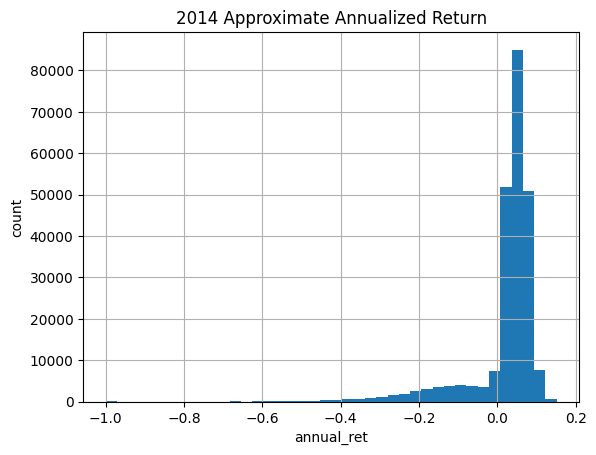

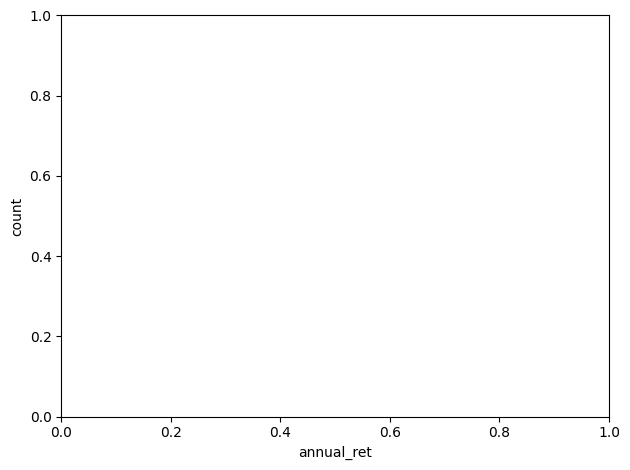

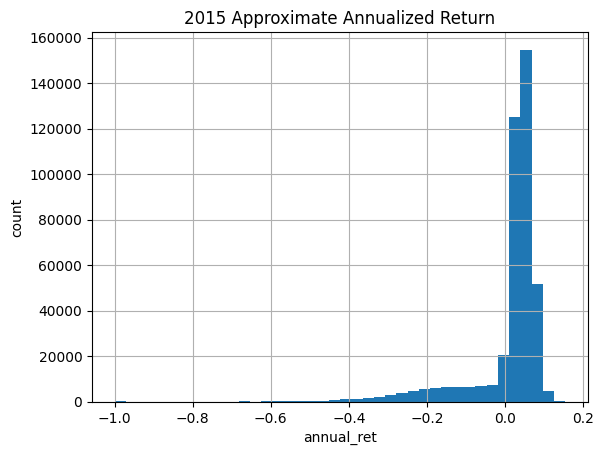

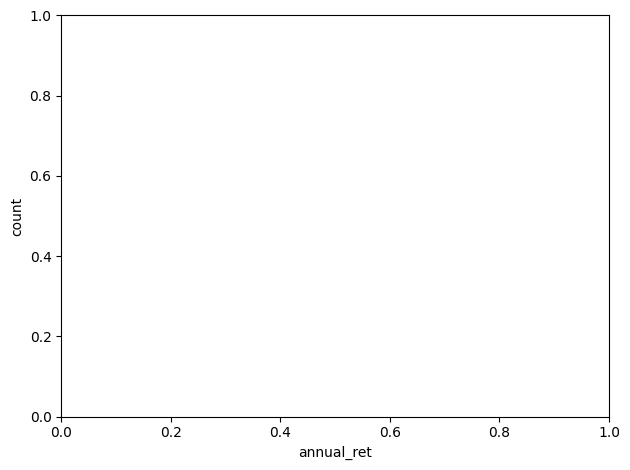

In [ ]:
def summarize_defaults(df, label):
    tmp = df.dropna(subset=['defaulted'])
    rate = tmp['defaulted'].mean()
    by_grade = tmp.groupby('grade')['defaulted'].mean().to_frame('default_rate') if 'grade' in tmp else pd.DataFrame()
    print(f"{label} Default Rate = {rate:.3f}")
    display(by_grade)

summarize_defaults(r14, '2014')
summarize_defaults(r15, '2015')

for label, df in [('2014', r14), ('2015', r15)]:
    tmp = df.dropna(subset=['annual_ret'])
    if not tmp.empty:
        tmp['annual_ret'].hist(bins=40)
        plt.title(f'{label} Approximate Annualized Return'); plt.xlabel('annual_ret'); plt.ylabel('count'); plt.show()
        plt.xlabel('annual_ret'); plt.ylabel('count')
        plt.tight_layout()
        plt.savefig(fig_path/f"{label.lower()}_annual_ret_hist.png", dpi=300)
        plt.show()

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def _make_ohe():
    # Handle sklearn API change: sparse_output (new) vs sparse (old)
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown='ignore', sparse=False)

def prep_features(df):
    base = df.copy()
    features = [
        'loan_amnt','term_months','int_rate','emp_length','home_ownership','annual_inc',
        'verification_status','purpose','dti','delinq_2yrs','open_acc','pub_rec',
        'revol_bal','revol_util','grade'
    ]
    feats = [f for f in features if f in base.columns]

    # parse emp_length to numeric years if present
    if 'emp_length' in base.columns:
        base['emp_length_num'] = pd.to_numeric(
            base['emp_length'].astype(str).str.extract(r'(\d+)', expand=False),
            errors='coerce'
        )
        if 'emp_length' in feats:
            feats.remove('emp_length')
        feats.append('emp_length_num')

    # split numeric vs categorical
    num = [f for f in feats if base[f].dtype.kind in 'ifc']
    cat = [f for f in feats if f not in num]

    X = base[feats].copy()

    num_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ])
    cat_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ohe', _make_ohe())
    ])

    ct = ColumnTransformer([
        ('num', num_pipeline, [c for c in feats if c in num]),
        ('cat', cat_pipeline, [c for c in feats if c in cat]),
    ])

    return X, ct

def kmeans_sweep(df, label):
    X, ct = prep_features(df)
    Xtr = ct.fit_transform(X)

    if getattr(Xtr, 'shape', (0, 0))[0] < 10:  # need at least a few rows
        raise ValueError(f"{label}: not enough rows after preprocessing for K-Means.")

    best = (None, -1, None)
    sil = {}
    for k in range(3, 9):
        km = KMeans(n_clusters=k, n_init=10, random_state=7)
        labs = km.fit_predict(Xtr)
        
        # Silhouette needs at least 2 clusters and fewer than n_samples clusters (already OK here)
        s = silhouette_score(Xtr, labs)
        sil[k] = s
        if s > best[1]:
            best = (km, s, labs)

    print(label, 'silhouette by k:', sil)
    return ct, best

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy import sparse
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Reduce features to 2D for plotting
def _to_2d(Xtr, random_state=7):
    if sparse.issparse(Xtr):
        reducer = TruncatedSVD(n_components=2, random_state=random_state)
    else:
        reducer = PCA(n_components=2, random_state=random_state)
    Z = reducer.fit_transform(Xtr)
    return Z, reducer

def _scatter_clusters(Z2, labels, centers_2d=None, title="", outfile=None):
    fig = plt.figure(figsize=(7,5))
    ax = plt.gca()
    ax.scatter(Z2[:,0], Z2[:,1], c=labels, s=6, alpha=0.7)
    if centers_2d is not None:
        ax.scatter(centers_2d[:,0], centers_2d[:,1],
                   s=120, marker="X", edgecolor="k")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_title(title)
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, dpi=200)
        plt.close(fig)
    else:
        plt.show()

def _plot_silhouette_curve(sil_dict, label, outfile=None):
    ks = sorted(sil_dict.keys())
    vals = [sil_dict[k] for k in ks]
    fig = plt.figure(figsize=(6.5,4))
    plt.plot(ks, vals, marker="o")
    plt.xticks(ks)
    plt.xlabel("k (number of clusters)")
    plt.ylabel("Silhouette score")
    plt.title(f"{label}: Silhouette by k")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, dpi=200)
        plt.close(fig)
    else:
        plt.show()

# Feature prep
def _make_ohe():
    return OneHotEncoder(handle_unknown="ignore", sparse=True)

def prep_features(df):
    base = df.copy()
    features = [
        'loan_amnt','term_months','int_rate','emp_length','home_ownership','annual_inc',
        'verification_status','purpose','dti','delinq_2yrs','open_acc','pub_rec',
        'revol_bal','revol_util','grade'
    ]
    feats = [f for f in features if f in base.columns]

    # parse emp_length
    if 'emp_length' in base.columns:
        base['emp_length_num'] = pd.to_numeric(
            base['emp_length'].astype(str).str.extract(r'(\d+)', expand=False),
            errors='coerce'
        )
        if 'emp_length' in feats:
            feats.remove('emp_length')
        feats.append('emp_length_num')

    num = [f for f in feats if base[f].dtype.kind in 'ifc']
    cat = [f for f in feats if f not in num]

    X = base[feats].copy()

    num_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ])
    cat_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ohe', _make_ohe())
    ])

    ct = ColumnTransformer([
        ('num', num_pipeline, [c for c in feats if c in num]),
        ('cat', cat_pipeline, [c for c in feats if c in cat]),
    ])
    return X, ct

# KMeans sweep
def kmeans_sweep(df, label, k_range=range(3,9), random_state=7,
                 make_plots=True, outdir=fig_path):
    X_df, ct = prep_features(df)
    Xtr = ct.fit_transform(X_df)

    if getattr(Xtr, "shape", (0,0))[0] < 10:
        raise ValueError(f"{label}: not enough rows after preprocessing for K-Means.")

    # Reduce dimensionality to speed up
    svd = TruncatedSVD(n_components=min(50, Xtr.shape[1]-1), random_state=random_state)
    Xred = svd.fit_transform(Xtr)

    best = {"best_km": None, "best_score": -1.0, "best_k": None, "labels": None}
    sil = {}

    for k in k_range:
        km = MiniBatchKMeans(n_clusters=k, random_state=random_state, batch_size=2048, n_init="auto")
        labs = km.fit_predict(Xred)

        # Sample silhouette
        s = silhouette_score(Xred, labs, sample_size=5000, random_state=random_state)
        sil[k] = float(s)
        if s > best["best_score"]:
            best.update(best_km=km, best_score=float(s),
                        best_k=int(k), labels=labs)

    # 2D embedding
    Z2, reducer = _to_2d(Xred, random_state=random_state)
    centers_2d = reducer.transform(best["best_km"].cluster_centers_)

    if make_plots:
        sil_out = os.path.join(outdir, f"{label}_silhouette_by_k.png")
        _plot_silhouette_curve(sil, label, outfile=sil_out)

        clus_out = os.path.join(outdir, f"{label}_clusters_2d.png")
        _scatter_clusters(Z2, best["labels"], centers_2d=centers_2d,
                          title=f"{label}: MiniBatch K-Means (k={best['best_k']}) – 2D projection",
                          outfile=clus_out)
        print(f"Saved {sil_out}")
        print(f"Saved {clus_out}")

    return {
        "ct": ct,
        "best_k": best["best_k"],
        "best_score": best["best_score"],
        "best_km": best["best_km"],
        "labels": best["labels"],
        "silhouette": sil,
        "Z2": Z2,
        "reducer": reducer,
    }

def _make_ohe():
    try:
        # for sklearn >= 1.2
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)          # fallback for older versions

def run_kmeans_for_year(df, year, label_prefix, k_range=range(3,9)):
    dfx = df.copy()
    if "cohort" in dfx.columns:
        dfx = dfx.loc[dfx["cohort"] == year]
        if len(dfx) == 0:
            raise ValueError(f"No rows for cohort {year}.")
    label = f"{label_prefix} {year}"
    return kmeans_sweep(dfx, label=label, k_range=k_range)

print("Ready to compute, fast kmeans_sweep is defined.")

# Example usage with df14/df15
res14 = run_kmeans_for_year(df14, 2014, label_prefix="LendingClub")
res15 = run_kmeans_for_year(df15, 2015, label_prefix="LendingClub")

print("2014 silhouette by k:", res14["silhouette"])
print("2015 silhouette by k:", res15["silhouette"])
print("Best k (2014), score:", res14["best_k"], res14["best_score"])
print("Best k (2015), score:", res15["best_k"], res15["best_score"])

Ready to compute, fast kmeans_sweep is defined.
Saved /Users/mlwu/Documents/Academia/CMU/tepper_courses/Business Value Through Integrative Analytics/cases/case_1/code/figs/LendingClub 2014_silhouette_by_k.png
Saved /Users/mlwu/Documents/Academia/CMU/tepper_courses/Business Value Through Integrative Analytics/cases/case_1/code/figs/LendingClub 2014_clusters_2d.png
Saved /Users/mlwu/Documents/Academia/CMU/tepper_courses/Business Value Through Integrative Analytics/cases/case_1/code/figs/LendingClub 2015_silhouette_by_k.png
Saved /Users/mlwu/Documents/Academia/CMU/tepper_courses/Business Value Through Integrative Analytics/cases/case_1/code/figs/LendingClub 2015_clusters_2d.png
2014 silhouette by k: {3: 0.06191670258486865, 4: 0.06732292727079625, 5: 0.08915265228953458, 6: 0.0799398359595311, 7: 0.08368952520317609, 8: 0.056337900498542544}
2015 silhouette by k: {3: 0.06714410321417753, 4: 0.06312441738074481, 5: 0.04064359222564601, 6: 0.03770290542548377, 7: 0.038010504466082194, 8: 0.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Summarize cluster profiles using medians of numeric features and cluster sizes
def profile_clusters(df, res, features=None):
    df = df.copy()
    df["cluster"] = res["labels"]

    # Default to numeric features only
    if features is None:
        features = df.select_dtypes(include=["number"]).columns.tolist()
    else:
        # keep only numeric features among those requested
        features = [f for f in features if f in df.columns and pd.api.types.is_numeric_dtype(df[f])]

    # Guard against cluster label being included
    features = [f for f in features if f != "cluster"]

    # Median profiles for numeric features
    prof = df.groupby("cluster")[features].median().round(2)

    # Add cluster sizes (always include this column)
    prof["n_loans"] = df.groupby("cluster").size()

    return prof

# Table of cluster profiles
def plot_profile_table(df, res, features, title, outfile=None, decimals=2):
    prof = profile_clusters(df, res, features=features).round(decimals)

    fig, ax = plt.subplots(figsize=(len(features)*1.5, 0.6*len(prof)+1))
    ax.axis("off")

    # Build table
    tbl = ax.table(
        cellText=prof.values,
        rowLabels=[f"C{i}" for i in prof.index],
        colLabels=prof.columns,
        loc="center",
        cellLoc="center"
    )

    # Formatting
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1.2, 1.2)

    # Bold headers
    for (row, col), cell in tbl.get_celld().items():
        if row == 0 or col == -1:
            cell.set_text_props(weight="bold")
        if row == 0:
            cell.set_facecolor("#f2f2f2")

    ax.set_title(title, weight="bold", pad=10)

    if outfile:
        plt.savefig(outfile, bbox_inches="tight", dpi=200)
        plt.close(fig)
    else:
        plt.show()

# Heatmap of cluster profiles
def plot_cluster_heatmap(df, res, features, title, outfile=None):
    prof = profile_clusters(df, res, features=features)

    fig, ax = plt.subplots(figsize=(len(features)*1.2+2, 0.6*len(prof)+1))
    im = ax.imshow(prof.values, cmap="Blues", aspect="auto")

    # Ticks
    ax.set_xticks(range(len(prof.columns)))
    ax.set_xticklabels(prof.columns, rotation=30, ha="right")
    ax.set_yticks(range(len(prof.index)))
    ax.set_yticklabels([f"C{i}" for i in prof.index])

    # Annotate cells
    for i in range(prof.shape[0]):
        for j in range(prof.shape[1]):
            ax.text(j, i, f"{prof.iloc[i, j]:.1f}",
                    ha="center", va="center", color="black", fontsize=8)

    fig.colorbar(im, ax=ax, shrink=0.8, label="Median Value")
    ax.set_title(title, weight="bold")

    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, dpi=200, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

def plot_feature_by_cluster(df, res, feature, title="", outfile=None):
    df = df.copy()
    df["cluster"] = res["labels"]
    prof = df.groupby("cluster")[feature].median()

    fig, ax = plt.subplots(figsize=(5,3))
    ax.bar(prof.index, prof.values, color="steelblue", edgecolor="black")
    ax.set_xticks(prof.index)
    ax.set_xticklabels([f"C{i}" for i in prof.index])
    ax.set_ylabel(f"Median {feature}")
    ax.set_title(title if title else f"{feature} by Cluster", weight="bold")

    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, dpi=200, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

features = ["loan_amnt","annual_inc","dti","int_rate","revol_util"]

plot_cluster_heatmap(df14, res14, features, title="2014 Cluster Profiles Heatmap",
                     outfile="figs/cluster_profiles_heatmap_2014.png")
plot_cluster_heatmap(df15, res15, features, title="2015 Cluster Profiles Heatmap",
                     outfile="figs/cluster_profiles_heatmap_2015.png")

for feat in ["annual_inc", "dti"]:
    plot_feature_by_cluster(df14, res14, feat, title=f"2014 {feat} by Cluster",
                            outfile=f"figs/2014_{feat}_by_cluster.png")
    plot_feature_by_cluster(df15, res15, feat, title=f"2015 {feat} by Cluster",
                            outfile=f"figs/2015_{feat}_by_cluster.png")

plot_profile_table(df14, res14, features, title="2014 Cluster Profiles",
                   outfile="figs/cluster_profiles_2014.png")

plot_profile_table(df15, res15, features, title="2015 Cluster Profiles",
                   outfile="figs/cluster_profiles_2015.png")

In [ ]:
# Summarize clusters with counts and outcomes if present
def cluster_summary(df, ct, km, label):
    X, _ = prep_features(df)
    Xtr = ct.transform(X)
    df = df.copy()
    df['cluster'] = km.predict(Xtr)
    print(f"\n{label} Cluster Sizes\n", df['cluster'].value_counts().sort_index())
    
    # Overlay outcomes
    if 'defaulted' in df:
        display(df.groupby('cluster')['defaulted'].mean().to_frame('default_rate'))
    if 'annual_ret' in df:
        display(df.groupby('cluster')['annual_ret'].median().to_frame('median_annual_ret'))
    return df

# Return (ct, best) for K-Means
def ensure_kmeans(df, label, nmax=10000):
    # use existing globals if present
    ct_var = f"ct{label[-2:]}"   # crude: 'ct14' / 'ct15'
    best_var = f"best{label[-2:]}"
    g = globals()
    ct = g.get(ct_var)
    best = g.get(best_var)

    # If missing or None, then recompute
    if best is None or best[0] is None:
        df_use = df.dropna(subset=['defaulted'])
        if len(df_use) == 0:
            raise ValueError(f"{label}: no rows with labeled 'defaulted' to cluster.")
        df_use = df_use.sample(min(nmax, len(df_use)), random_state=7)
        ct, best = kmeans_sweep(df_use, label)
        g[ct_var] = ct
        g[best_var] = best
    return ct, best

# Run safely for 2014 - 2015
ct14, best14 = ensure_kmeans(r14, '2014')
ct15, best15 = ensure_kmeans(r15, '2015')

# Only call cluster_summary if we have a trained KMeans
if best14[0] is not None:
    df14c = cluster_summary(r14.dropna(subset=['defaulted']).copy(), ct14, best14[0], '2014')
if best15[0] is not None:
    df15c = cluster_summary(r15.dropna(subset=['defaulted']).copy(), ct15, best15[0], '2015')

AttributeError: 'dict' object has no attribute 'dropna'


2014 Cluster vs Grade (row-normalized)


grade,A,B,C,D,E,F,G
cluster,,,,,,,
0,0.005,0.092,0.301,0.321,0.193,0.065,0.022
1,0.321,0.331,0.232,0.088,0.024,0.004,0.001
2,0.181,0.335,0.288,0.136,0.046,0.012,0.001



2015 Cluster vs Grade (row-normalized)


grade,A,B,C,D,E,F,G
cluster,,,,,,,
0,0.011,0.143,0.308,0.246,0.208,0.068,0.016
1,0.218,0.336,0.292,0.118,0.031,0.004,0.001
2,0.338,0.347,0.223,0.068,0.021,0.002,0.000


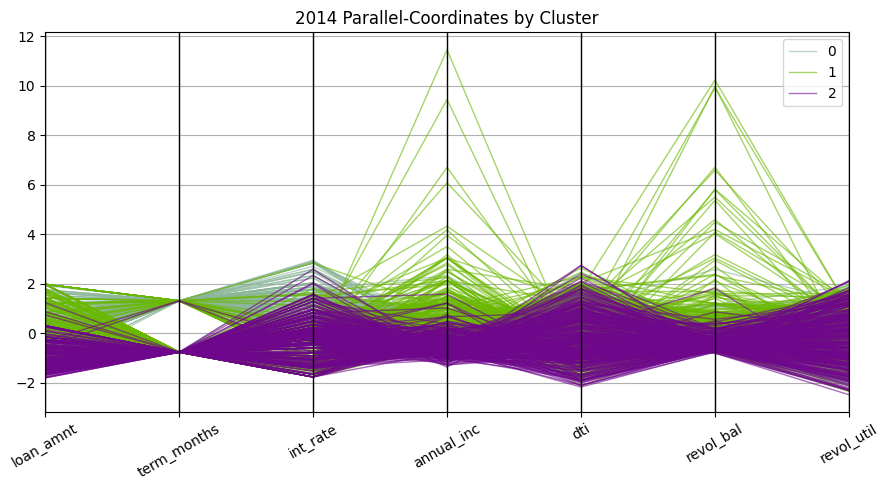

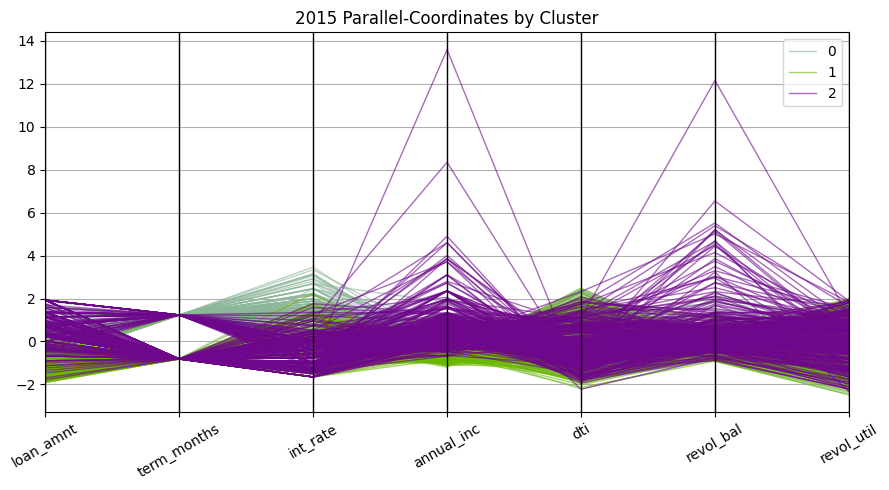

In [ ]:
from pandas.plotting import parallel_coordinates

# Cross-tab cluster vs grade if present
def cluster_grade_ct(df, label):
    if 'cluster' not in df.columns or 'grade' not in df.columns:
        print(label, 'missing cluster or grade'); return
    ct = pd.crosstab(df['cluster'], df['grade'], normalize='index').round(3)
    print(f"\n{label} Cluster vs Grade (row-normalized)")
    display(ct)

# If present, then reuse clustered frames \\ otherwise compute from best models
if 'df14c' in globals():
    cluster_grade_ct(df14c, '2014')
if 'df15c' in globals():
    cluster_grade_ct(df15c, '2015')

# Parallel coordinates plot by cluster
def parallel_plot(df, label, feats=None, n_per_cluster=300):
    if 'cluster' not in df.columns:
        print(label, 'no cluster column'); return
    if feats is None:
        feats = ['loan_amnt','term_months','int_rate','annual_inc','dti','revol_bal','revol_util']
        feats = [f for f in feats if f in df.columns]
    tmp = df.dropna(subset=feats + ['cluster']).copy()

    # Sample balanced per cluster for readability
    frames = []
    for k, g in tmp.groupby('cluster'):
        frames.append(g.sample(min(n_per_cluster, len(g)), random_state=7))
    samp = pd.concat(frames, ignore_index=True)

    # Compute z-score
    Z = (samp[feats] - samp[feats].mean())/samp[feats].std(ddof=0)
    Z['cluster'] = samp['cluster'].astype(str)
    plt.figure(figsize=(9,5))

    # Parallel coordinates plot 
    parallel_coordinates(Z, 'cluster', linewidth=1, alpha=0.6)
    plt.title(f'{label} Parallel-Coordinates by Cluster')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig(fig_path/f"{label.lower()}_parallel_coords.png", dpi=300)
    plt.show()

# If present, then plot
if 'df14c' in globals():
    parallel_plot(df14c, '2014')
if 'df15c' in globals():
    parallel_plot(df15c, '2015')

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,open_acc,pub_rec,revol_bal,revol_util,term_months,cluster,default_rate,med_ann_ret,top_grade,top_purpose,top_home_ownership,top_verification_status
cluster,,,,,,,,,,,,,,,,,
0,18000.0,16.59,68000.0,19.26,0.0,11.0,0.0,14509.0,61.4,60.0,0.0,0.277,0.0478,"D, C, E","debt_consolidation, credit_card, home_improvement","MORTGAGE, RENT, OWN","Source Verified, Verified, Not Verified"
1,24000.0,10.99,111000.0,16.64,0.0,14.0,0.0,26582.0,59.3,36.0,1.0,0.107,0.0407,"B, A, C","debt_consolidation, credit_card, home_improvement","MORTGAGE, RENT, OWN","Source Verified, Verified, Not Verified"
2,9000.0,12.85,52860.0,17.01,0.0,10.0,0.0,8265.0,52.5,36.0,2.0,0.145,0.0452,"B, C, A","debt_consolidation, credit_card, other","RENT, MORTGAGE, OWN","Not Verified, Source Verified, Verified"


,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,open_acc,pub_rec,revol_bal,revol_util,term_months,cluster,default_rate,med_ann_ret,top_grade,top_purpose,top_home_ownership,top_verification_status
cluster,,,,,,,,,,,,,,,,,
0,18825.0,15.61,67028.22,20.77,0.0,11.0,0.0,14223.0,58.9,60.0,0.0,0.294,0.0418,"C, D, E","debt_consolidation, credit_card, home_improvement","MORTGAGE, RENT, OWN","Source Verified, Verified, Not Verified"
1,9600.0,11.53,55000.00,17.81,0.0,10.0,0.0,8748.0,49.9,36.0,1.0,0.154,0.0400,"B, C, A","debt_consolidation, credit_card, other","RENT, MORTGAGE, OWN","Source Verified, Not Verified, Verified"
2,25000.0,9.99,120000.00,17.29,0.0,14.0,0.0,31279.0,59.6,36.0,2.0,0.117,0.0369,"B, A, C","debt_consolidation, credit_card, home_improvement","MORTGAGE, RENT, OWN","Source Verified, Verified, Not Verified"


2014 explained variance (PC1..PC3): [0.212 0.154 0.127]


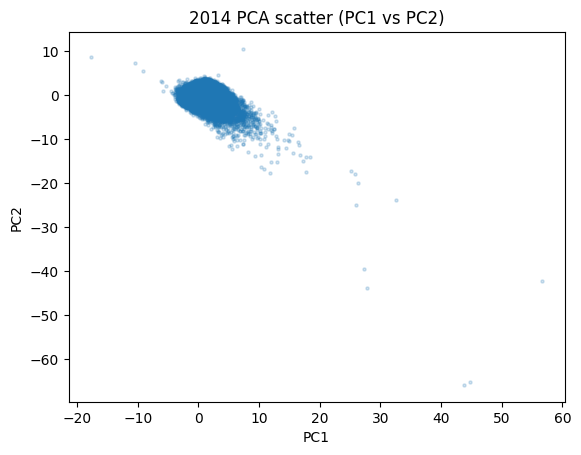

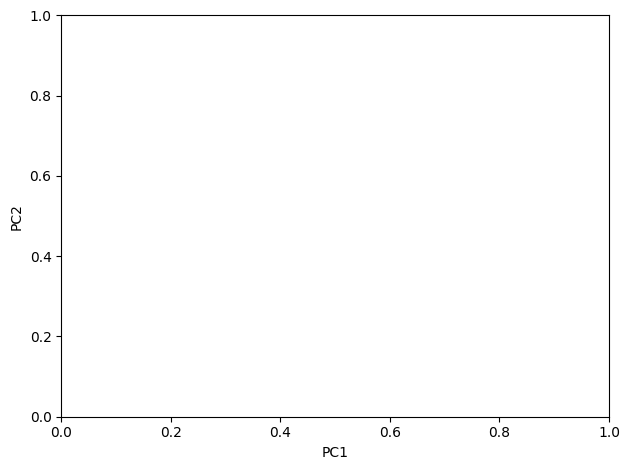

2015 explained variance (PC1..PC3): [0.205 0.15  0.124]


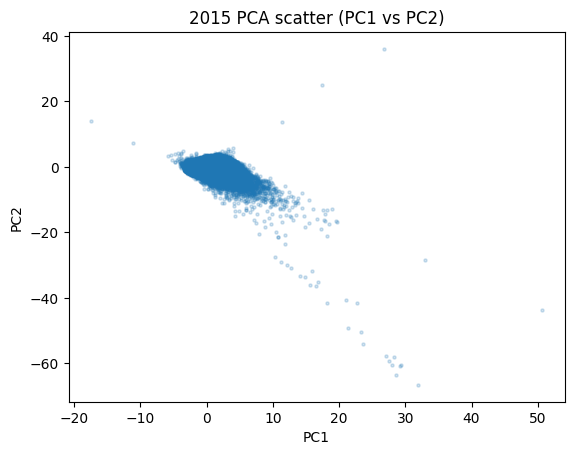

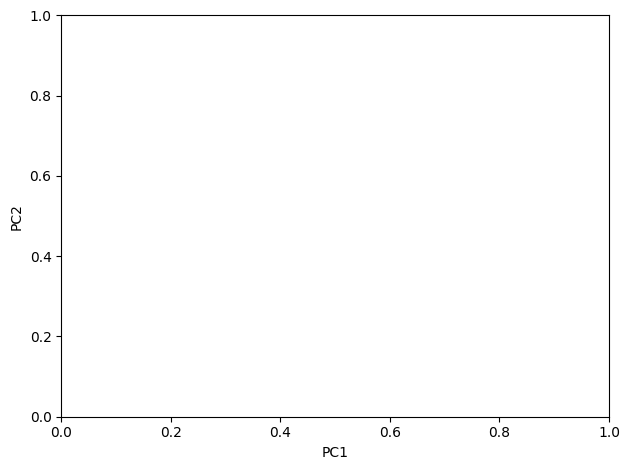

,PC1,PC2,PC3
loan_amnt,0.524309,-0.145755,-0.166447
revol_bal,0.432168,-0.272212,0.127117
term_months,0.411782,0.344561,-0.216897
annual_inc,0.334816,-0.481703,-0.293543
open_acc,0.264354,-0.188927,0.543663
revol_util,0.257279,0.278901,-0.113543
int_rate,0.255443,0.577723,-0.184777
dti,0.181735,0.314567,0.651893
pub_rec,-0.148180,0.087459,-0.233805
delinq_2yrs,0.018768,-0.007190,-0.026282


,PC1,PC2,PC3
loan_amnt,0.512208,-0.177380,-0.210301
term_months,0.444632,0.298772,-0.237468
revol_bal,0.408133,-0.347831,0.129341
int_rate,0.298953,0.560444,-0.172637
open_acc,0.269981,-0.197003,0.589165
revol_util,0.268192,0.185157,-0.169919
annual_inc,0.250500,-0.512178,-0.279829
dti,0.244439,0.314804,0.614940
pub_rec,-0.129143,0.098228,-0.142707
delinq_2yrs,0.002109,-0.004132,-0.006435


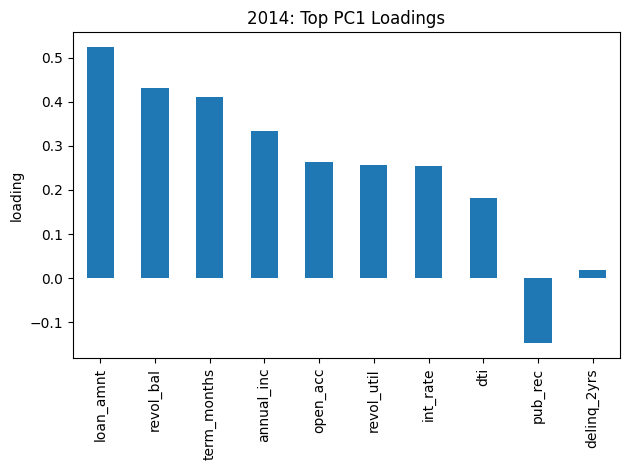

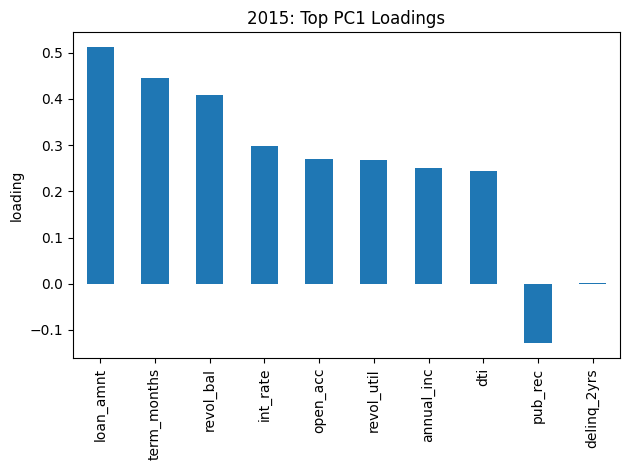

In [ ]:
from sklearn.decomposition import PCA

# expects df with 'cluster' and 'defaulted','annual_ret' present
def cluster_prototypes(df, n_top_cats=3):
    num_exclude = {'defaulted','roi','annual_ret','ret_opt','ret_int','ret_pess',
                   'ret_opt_ann','ret_int_ann','ret_pess_ann','funded_amnt','total_pymnt','recoveries'}
    num = [c for c in df.select_dtypes(include='number').columns if c not in num_exclude]
    cat = [c for c in ['grade','purpose','home_ownership','verification_status'] if c in df.columns]
    by = df.groupby('cluster')
    proto_num = by[num].median().round(2)
    rows = []
    for k,g in by:
        tops = {f'top_{c}': ', '.join(g[c].astype(str).value_counts().head(n_top_cats).index.tolist()) for c in cat}
        rows.append({'cluster': k,
                     'default_rate': g['defaulted'].mean().round(3),
                     'med_ann_ret': g['annual_ret'].median().round(4),
                     **tops})
    proto_cat = pd.DataFrame(rows).set_index('cluster')
    proto = proto_num.join(proto_cat).sort_index()
    return proto

# Show and save
display(cluster_prototypes(df14c))
display(cluster_prototypes(df15c))
cluster_prototypes(df14c).to_csv(data_out/"cluster_prototypes_2014.csv")
cluster_prototypes(df15c).to_csv(data_out/"cluster_prototypes_2015.csv")

# PCA on numeric features
def pca_plot(df, label):
    feats = ['loan_amnt','term_months','int_rate','annual_inc','dti','delinq_2yrs','open_acc','pub_rec','revol_bal','revol_util']
    feats = [f for f in feats if f in df.columns]
    X = df[feats].dropna()
    if X.empty:
        print(label, 'no numeric data for PCA');
        return None
    
    Xz = (X - X.mean())/X.std(ddof=0)
    pca = PCA(n_components=3, random_state=7)
    Z = pca.fit_transform(Xz)
    exp = pca.explained_variance_ratio_

    print(label, 'explained variance (PC1..PC3):', np.round(exp, 3))
    plt.scatter(Z[:,0], Z[:,1], s=5, alpha=0.2)
    plt.title(f'{label} PCA scatter (PC1 vs PC2)'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()
    plt.xlabel('PC1'); plt.ylabel('PC2')

    plt.tight_layout()
    plt.savefig(fig_path/f"{label.lower()}_pca_scatter.png", dpi=300)
    plt.show()

    loadings = pd.DataFrame(pca.components_.T, index=feats, columns=['PC1','PC2','PC3']).sort_values('PC1', key=lambda s: s.abs(), ascending=False)
    return loadings

load14 = pca_plot(r14, '2014')
load15 = pca_plot(r15, '2015')

# Show then save loadings
display(load14.head(10) if load14 is not None else 'n/a')
display(load15.head(10) if load15 is not None else 'n/a')
load14.to_csv(data_out/"pca_loadings_2014.csv")
load15.to_csv(data_out/"pca_loadings_2015.csv")

def pca_top_loadings_bar(loadings, pc='PC1', top=10, title='Top PC1 Loadings'):
    imp = loadings[pc].abs().sort_values(ascending=False).head(top).index
    vals = loadings.loc[imp, pc]
    vals.plot(kind='bar'); plt.title(title); plt.ylabel('loading'); plt.tight_layout(); plt.show()

pca_top_loadings_bar(load14, 'PC1', 10, '2014: Top PC1 Loadings')
pca_top_loadings_bar(load15, 'PC1', 10, '2015: Top PC1 Loadings')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path

# Fit PCA on transformed features
X, ct = prep_features(df)
Xtr = ct.fit_transform(X)
pca = PCA().fit(Xtr)

# Plot scree plot (individual + cumulative explained variance)
fig, ax = plt.subplots(figsize=(6, 4))
components = np.arange(1, len(pca.explained_variance_ratio_) + 1)

ax.plot(components, pca.explained_variance_ratio_, marker="o", label="Individual")
ax.plot(components, np.cumsum(pca.explained_variance_ratio_), marker="s", label="Cumulative")

ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance Ratio")
ax.set_title("PCA Scree Plot")
ax.legend()
ax.grid(alpha=0.3)

fig.tight_layout()
fig.savefig(fig_path / "pca_scree.png", dpi=200)
plt.show()


NameError: name 'prep_features' is not defined

In [ ]:
# Imbalance report
def imbalance_report(df, label):
    tmp = df.dropna(subset=['defaulted'])
    if tmp.empty:
        print(label, 'no labeled expired loans'); return
    rate = tmp['defaulted'].mean()
    print(f"{label} minority (default=1) share = {rate:.3f}")
    return rate

imbalance_report(r14, '2014')
imbalance_report(r15, '2015')

# Demonstrate SMOTE if imblearn is available (optional)
try:
    from imblearn.over_sampling import SMOTE
    print('imblearn available — demonstrating SMOTE on a tiny numeric subset...')
    tmp = r14.dropna(subset=['defaulted'])
    feats = ['loan_amnt','term_months','int_rate','annual_inc','dti','revol_bal','revol_util']
    feats = [f for f in feats if f in tmp.columns]
    X = tmp[feats].fillna(tmp[feats].median())
    y = tmp['defaulted'].astype(int)
    Xb, yb = SMOTE(random_state=7).fit_resample(X, y)
    print('Before:', y.value_counts().to_dict(), 'After:', pd.Series(yb).value_counts().to_dict())
except Exception as e:
    print('imblearn not installed in this environment; code path left for local run.')

2014 minority (default=1) share = 0.177
2015 minority (default=1) share = 0.191
imblearn available — demonstrating SMOTE on a tiny numeric subset...
Before: {0: 193881, 1: 41748} After: {0: 193881, 1: 193881}


In [ ]:
def cohen_returns(df):
    df = df.copy()
    status = df['loan_status'].astype(str).str.lower()
    # Optimistic: treat late loans as fully paid
    df['roi_opt'] = (df['total_pymnt'] - df['funded_amnt']) / df['funded_amnt']
    # For optimistic, nothing extra (all late loans as-is)
    # Pessimistic: treat late loans as defaulted (roi=-1)
    late_mask = status.str.contains('late') | status.str.contains('grace')
    df.loc[late_mask, 'roi_pess'] = -1.0
    df.loc[~late_mask, 'roi_pess'] = df.loc[~late_mask, 'roi_opt']
    # Intermediate: partial credit for late statuses
    df['roi_int'] = df['roi_opt']
    df.loc[status.str.contains('grace'), 'roi_int'] *= 0.5
    df.loc[status.str.contains('late \(16-30\)'), 'roi_int'] *= 0.25
    df.loc[status.str.contains('late \(31-120\)'), 'roi_int'] = -1.0
    return df

r14 = cohen_returns(r14)
r15 = cohen_returns(r15)
r14[['loan_status','roi_opt','roi_pess','roi_int']].head(5)

<>:14: SyntaxWarning: invalid escape sequence '\('
<>:15: SyntaxWarning: invalid escape sequence '\('
<>:14: SyntaxWarning: invalid escape sequence '\('
<>:15: SyntaxWarning: invalid escape sequence '\('
/var/folders/s1/_87stjnd5c12cm_bjtxx4xlm0000gn/T/ipykernel_2310/2425941609.py:14: SyntaxWarning: invalid escape sequence '\('
  df.loc[status.str.contains('late \(16-30\)'), 'roi_int'] *= 0.25
/var/folders/s1/_87stjnd5c12cm_bjtxx4xlm0000gn/T/ipykernel_2310/2425941609.py:15: SyntaxWarning: invalid escape sequence '\('
  df.loc[status.str.contains('late \(31-120\)'), 'roi_int'] = -1.0


,loan_status,roi_opt,roi_pess,roi_int
0,Fully Paid,0.159491,0.159491,0.159491
1,Charged Off,-0.364261,-0.364261,-0.364261
2,Charged Off,-0.701702,-0.701702,-0.701702
3,Fully Paid,0.497293,0.497293,0.497293
4,Fully Paid,0.190768,0.190768,0.190768


In [ ]:
def cluster_grade_crosstab(df, label):
    if 'cluster' in df and 'grade' in df:
        ct = pd.crosstab(df['cluster'], df['grade'], normalize='index')
        print(label, 'Cluster vs Grade Distribution (row-norm)')
        display(ct)
cluster_grade_crosstab(df14c, '2014')
cluster_grade_crosstab(df15c, '2015')

2014 Cluster vs Grade Distribution (row-norm)


grade,A,B,C,D,E,F,G
cluster,,,,,,,
0,0.004826,0.092228,0.301218,0.321259,0.192981,0.065107,0.022381
1,0.320921,0.330661,0.231987,0.088359,0.023551,0.003646,0.000874
2,0.181391,0.334802,0.288252,0.136257,0.046068,0.012431,0.000799


2015 Cluster vs Grade Distribution (row-norm)


grade,A,B,C,D,E,F,G
cluster,,,,,,,
0,0.010983,0.142817,0.308040,0.246156,0.207847,0.068278,0.015879
1,0.218152,0.336199,0.292286,0.117520,0.031067,0.004223,0.000553
2,0.338251,0.346619,0.223377,0.068296,0.020896,0.002301,0.000259


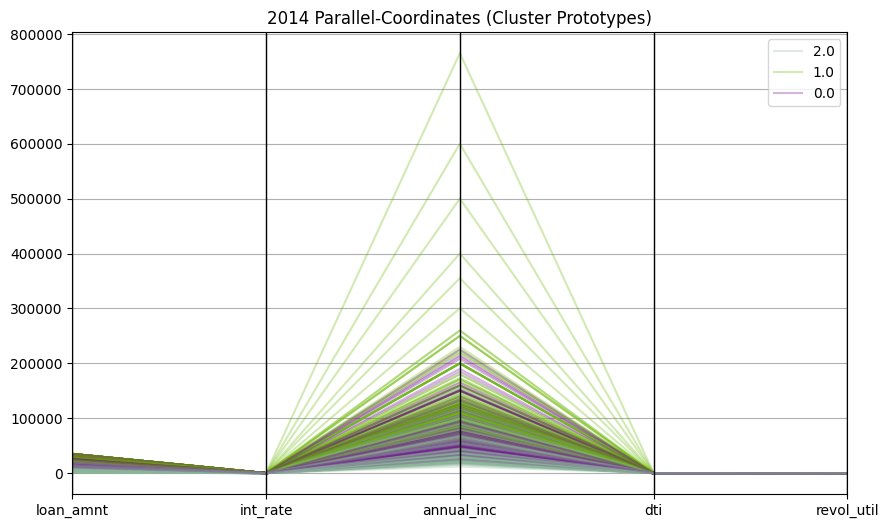

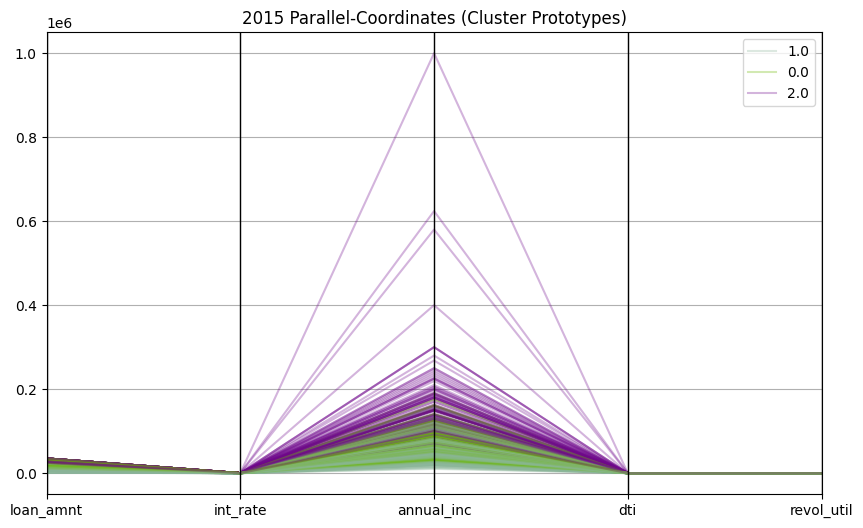

In [ ]:
from pandas.plotting import parallel_coordinates

def parallel_plot(df, label):
    feats = ['loan_amnt','int_rate','annual_inc','dti','revol_util']
    tmp = df.dropna(subset=feats+['cluster']).copy()

    # sample to keep plot light
    tmp = tmp.sample(min(1000, len(tmp)), random_state=7)
    plt.figure(figsize=(10,6))
    parallel_coordinates(tmp[['cluster']+feats].astype(float), 'cluster', alpha=0.3)
    plt.title(f'{label} Parallel-Coordinates (Cluster Prototypes)')
    plt.show()
parallel_plot(df14c, '2014')
parallel_plot(df15c, '2015')